<a href="https://colab.research.google.com/github/tomradch/MSCIDS_Computational_Language_Technologies/blob/main/CLT_Milestone1_Thomas_Radinger_1305.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SwissText Challenge: Detecting greenwashing signals through a comparison of ESG reports and public media
## HSLU CLT Project Milestone 1, Submission by Thomas Radinger

In recent years, there has been growing concern about the environmental impact of companies across various industries. As consumers become more environmentally conscious, companies are increasingly under pressure to demonstrate their commitment to sustainability. However, some companies may engage in "greenwashing" - the practice of making false or exaggerated claims about the environmental benefits of their products or services.

To analyze the extent of this issue, we will be working on a Natural Language Processing (NLP) project to analyze corporate sustainability reports and identify potential cases of greenwashing. Our dataset ('corpus') is provided by [SwissText](https://www.swisstext.org/shared-task-1-detecting-greenwashing-signals-through-a-comparison-of-esg-reports-and-public-media/), the Swiss Text Analytics Conference 2023. It contains 11 188 documents related to the Environmental, Social, and Governance (ESG) frameworks of companies listed on the German stockmarket (DAX). These documents stem both from companies themselves and from third parties.

The project involves various steps, including data cleaning and preprocessing, exploratory data analysis, and machine learning to develop a classification model that can detect greenwashing. This is the first in a series of notebooks, in which we carry out the preprocessing and cleaning and exploratory data analysis. The project is carried out as part of the Computational Language Technologies (CLT) module for the MSc in Applied Information and Data Science (IDS) at Lucerne University of Applied Sciences and Arts (HSLU) in spring 2023, taught by Dr. Diego Antognini and Dr. Guang Lu. 

Besides the course materials, the work draws on resources such as Practical Natural Language Processing by Sowmya Vajjala et al (https://www.practicalnlp.ai/) and A Beginner’s Guide to Exploratory Data Analysis (EDA) on Text Data (https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/).

A GitHub repository was also set up, accessible at: https://github.com/tomradch/MSCIDS_Computational_Language_Technologies

EDITS 13/05: for work on the second milestone, some changes were made to this notebook to facilitate analysis at the sentence level and to store the pre-processed dataframe for import in a separate notebook.

## Part 1. Data preprocessing and cleaning

### Basic data pre-processing
We first start by importing the necessary libraries and reading in our dataset. Some preliminary steps are also required to work with Google colab.

In [ ]:
# we install some libraries in the colab environment
!pip install contractions
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# we connect to googledrive to get our data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We load the necessary packages
import re
import unicodedata
from collections import Counter

import contractions
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from langdetect import detect
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from textblob import TextBlob

In [ ]:
# We download necessary NLTK data for our work with text corpus later on
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Taking a look at the first couple of observations in our dataset, we see that we have information on company, the actual content of the document, the type of the document, publication, topics related to each document, etc.

In [ ]:
# We load data into a dataframe and view the first rows of our dataset
df = pd.read_csv('/content/drive/MyDrive/esg_documents_for_dax_companies.csv', delimiter = '|', index_col = 0)
df.head()

KeyboardInterrupt: ignored

Inspecting the structure and content of our dataset a bit further, we see that we have 11 188 entries for a total of 10 variables, which are mostly of the datatype "object". 

In [ ]:
# we inspect the structure and content of our dataset
df.info()

Let's see how many "internal" and "external" sources we have in our corpus, and how many documents we have for our different companies. We see that there are only 92 documents produced by companies, compared to 11 096 documents stemming from external sources. 

In [ ]:
# We inspect the categories and counts of the "internal" variable
internal_counts = df['internal'].value_counts(dropna=False)
print(internal_counts)

There are only very few documents for some companies, including Muenchener Rueckversicherungs Gesellschaft AG, Fresenius and Hannover R AG.

In [ ]:
company_counts = df['company'].value_counts(dropna=False)
plt.figure(figsize=(10,6))
company_counts.plot.bar()
plt.title('Number of documents, by company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Nevertheless, broken down by type of document, we see that the number of internal documents per company is more homogeneously distributed, but that some companies have very few to no external documents. This limitation will be important to take into account when drawing conclusions of our analysis for these companies. For now, we keep all observations in our dataframe, but we may want to revisit this issue at a later stage.

In [ ]:
# We group the data by company and internal columns
grouped_df = df.groupby(['company', 'internal']).size().unstack(fill_value=0)

# We create two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# We plot the count of external documents by company
grouped_df[0].sort_values().plot(kind='barh', ax=axes[0], color='tab:blue')
axes[0].set_title('Number of external documents, by company')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Company')

# and we plot the count of internal documents by company
grouped_df[1].sort_values().plot(kind='barh', ax=axes[1], color='tab:green')
axes[1].set_title('Number of internal documents, by company')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Since we can already see some inconsistencies in the names of our companies, we clean these strings right away, transforming them into lower case, removing trailing whitespaces and legal forms of companies, for example. For this, we use regular expressions and string operations. We actually also observe that our dataset includes a company that is not included in the German stock market index, the DAX, namely 'Akzonobel', a Dutch company. In line with the focus of our project, we remove these observations.

In [ ]:
# We define a function to clean our company name values
def clean_company_name(company_name):
    # Remove common legal forms
    company_name = re.sub(r'\b(?:AG|SE|AGin Muenchen|KGaA)\b', '', company_name)

    # Replace specific company names
    replacements = {
        'AkzoNobelNV': 'AkzoNobel',
        'E ONSE': 'EON',
        'Hannover R': 'Hannover Rueck',
        'Muenchener Rueckversicherungs Gesellschaft': 'Muenchener Rueck'
    }
    company_name = replacements.get(company_name.strip(), company_name.strip())
    
    # Replace multiple consecutive whitespaces with a single whitespace
    company_name = re.sub(r'\s+', ' ', company_name)

    # Convert all characters to lowercase (or title case)
    company_name = company_name.lower()

    return company_name

# Apply the cleaning function to the 'company' column
df['company'] = df['company'].apply(clean_company_name)

# Drop all observations for the company name "AkzoNobel"
df = df[df['company'] != 'akzonobel']

# Check the cleaned company names
companies = df['company'].unique()
print(companies)

We perform some further essential basic data pre-processing steps, examining our dataset for missing and unwanted data. We do not need the columns on the 'url' and the 'domain', for example, so we drop these from our dataframe.

In [ ]:
# We drop unwanted columns from our dataframe
df.drop(['url', 'domain'], axis=1, inplace=True)

We also make sure our data are in the correct format. We therefore convert the "date" column to a datetime object, so we can run time-based analyses. We use the errors='coerce' parameter to replace invalid dates with NaT (Not-a-Time) values. In a first step (omitted here) we saw that our dataset actually contained errors for some observations.

We see that our corpus covers documents from 31 March 2020 to 2 June 2023. The maximum value seems strange, since our dataset was made available 10 April 2023. We therefore dig deeper into these values and remove any observations later than 10 April 2023. As becomes clear, only two observations are concerned by this issue.

In [ ]:
# First, we convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# then we inspect the "date" column
print(df['date'].describe())

In [ ]:
# We get an idea of the number of observations concerned
print(df['date'].value_counts())

# And we only keep those observations within our valid date range, as well as observations with missing values
df = df[(df['date'].isna()) | (df['date'] <= '2023-04-10')]


We still see if we can infer the information on the year that was wrongly encoded from the "title" column. Unfortunately, this variable contains no further information, but the same error ('p.DE' instead of the year), so we leave the missing values as is.

In [ ]:
# Now we display rows with invalid dates (NaT values)
invalid_rows = df.loc[df['date'].isna(), ['company', 'date', 'title']]
print("Rows with invalid dates:")
print(invalid_rows)

Now that we have the information on the date of publication for each document in our corpus, we can plot their evolution over time, again broken down by company. To try something different, we use a heatmap first, which actually reveals some outliers (see EON and Siemens Healthineers). This is also clear when we look at the summary statistics.

In [ ]:
# Group the dataframe by company and date and count the number of observations in each group
df_counts = df.groupby(['company', 'date']).size().reset_index(name='counts')
# print(df_counts)

# Pivot the resulting dataframe
df_pivot = df_counts.pivot(index='date', columns='company', values='counts')
# print(df_pivot)

print(df_counts.describe())

In [ ]:
# We create a heatmap of the counts of each company for each date
plt.figure(figsize=(12, 6))
sns.heatmap(df_pivot, cmap='YlGnBu')
plt.xlabel('Company')
plt.ylabel('Date')
plt.title('Counts of documents by company over time')
plt.show()

We then check for missing values in the other columns of our dataset. Looking at the "content" column that includes the text of our reports that we want to analyse, we see that there is one row with missing values. 

In [ ]:
# We check for missing values in other columns
missing_values = df.isna().sum()
print(missing_values)

So we simply drop this row without any text. It turns out, this is the same row that has the missing value in the "symbol" column, so no imputation is necessary. 

In [ ]:
# We select and display those rows with missing values in the datatype column
missing_content_row = df.loc[df['content'].isna()]
print(missing_content_row)

# We drop rows with missing text in the "content" column
df = df.dropna(subset=['content'])

We also inspect the rows with missing values in the "datatype" column more closely. We get an understanding of the categories of this variable, and the number of observations in each category. We have 51 sustainability reports and 38 annual reports in our dataset. 

In [ ]:
# We inspect the categories and counts of the "datatype" variable
datatype_counts = df['datatype'].value_counts(dropna=False)
print(datatype_counts)

Looking at those observations with missing values in the "datatype" column, we see that this concerns only external documents. However, from a closer reading, we can also see that some documents may be wrongly classified. For example, the "Dräger Sustainability Report 2020" is classified as being external, similar to the "Merck Sustainability Report 2021". We have valid reasons to assume that these and similar cases are internal documents, so we recode the variable where necessary. For other observations with missing values in the "datatype" column, we impute the value with the most frequent observations, that is the mode. 

In [ ]:
# We select and display those rows with missing values in the datatype column
missing_datatype_rows = df.loc[df['datatype'].isna(), ['company', 'datatype', 'title', 'internal']]
print(missing_datatype_rows)

In [ ]:
# We recode the "internal" variable based on the "title" column, no matter if in capitals or lower case
print("Counts of 'internal' variable before:")
print(df['internal'].value_counts())

condition = df['title'].str.contains('Sustainability Report|Annual Report', case=False)
df.loc[condition, 'internal'] = 1

# Check the updated "internal" column
print("Counts of 'internal' variable after:")
print(df['internal'].value_counts())

# We impute missing values in the "datatype" column with the mode
print("Counts of 'datatype' variable before:")
print(df['datatype'].value_counts())

mode_datatype = df['datatype'].mode().iloc[0]
df['datatype'].fillna(mode_datatype, inplace=True)

print("Counts of 'datatype' variable after:")
print(df['datatype'].value_counts())

Finally, we saw in the first rows of our dataframe that the 'esg_topics' variable contains a list for each observation. This will be difficult to work with, if we explore these topics further later on, so we one-hot encode this variable. That means creating a dedicated column per unique topic, labelling a row with 1 if it contains this topic, or 0 otherwise. We use sci-kit-learn's MultiLabelBinarizer.

In [ ]:
# We ensure that the esg_topics column contains lists and handle missing or invalid data
def process_topics(x):
    if isinstance(x, str):
        x = x.strip("[]").split(", ")
        return [item.strip("'") for item in x]
    else:
        return []

df['esg_topics'] = df['esg_topics'].apply(process_topics)

# We use MultiLabelBinarizer to one-hot encode the ESG topics
mlb = MultiLabelBinarizer()
one_hot_encoded_topics = mlb.fit_transform(df['esg_topics'])

# We create a new df with binary columns for each unique ESG topic
one_hot_encoded_topics_df = pd.DataFrame(one_hot_encoded_topics, columns=mlb.classes_, index=df.index)

# .. and concatenate the original df with the one-hot encoded topics
df = pd.concat([df, one_hot_encoded_topics_df], axis=1)

### Text cleaning and linguistic processing

Let's now get to our next part, we take a closer look at and clean and process our textual data. This serves to make our text more understandable but also to get better insights later on. We already cleaned the text of our company names. Our analysis will mainly be based on the content of the documents for each company. So we focus on this element of our dataset here. 

We will run methods to ensure the quality of our data (e.g. handling typos), to normalize our text (e.g. lowercasing, removing punctuation) to improve consistency and reduce dimensionality in our data, and apply other common text pre-processing techniques, including splitting our document into tokens, removing stop words, and and lemmatizing words.

First, however, we take a look at the language in which our documents are written and the encoding used to represent our text data. While we assume that the documents in our corpus are in English, we check the language actually used, making use of Python's langdetect library. As it turns out, the majority of our documents are indeed in English, but our corpus includes documents in other languages, from French to Swahili. We could translate these documents, using a Deepl API, for example. For simplicity, we just exclude any languages other than English here.

In [ ]:
# we define our function to detect the language for a given text
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# We apply the function to the 'content' column and store the result in a new variable
df['language'] = df['content'].apply(detect_language)

language_counts = df['language'].value_counts()
print(language_counts)

# We have a look at some of these documents  in our corpus.
print(df[df['language'] == 'pl'])

In [ ]:
# We filter our dataframe to exclude rows with languages other than English
df = df[df['language'] == 'en']

Next, we carry out some unicode normalization to avoid that potential encoding issues result in processing errors further down our pipeline.

In [ ]:
# Unicode normalization
def normalize_unicode(text, normalization_form='NFC'):
    return unicodedata.normalize(normalization_form, text)

# Apply the function to the "content" column
df['content'] = df['content'].apply(normalize_unicode)

We then start with cleaning our text. The best way for determining the steps required is to take a look at some of the documents in our corpus. We do so separately for different "datatypes", since the type of document may influence the types of noise it containts (e.g. HTML tags in web documents). We observe that the general noise seems to be similar.

In [ ]:
# We run the cell below a few times, taking a look at our text and the raw data.
def display_text_samples_by_datatype(df, datatype, num_samples=10):
    df_filtered = df[df['datatype'] == datatype]
    print(df_filtered['content'].sample(num_samples).values)

# We can replace 'company_website' with any other datatype to explore text samples from different categories
# categories: general, business, tech, thinktank, esg, science, sustainability_report, annual_report, company_website
display_text_samples_by_datatype(df, 'annual_report')

Based on general practice, and the nature of our texts, we carry out the following steps:
- Expanding contractions
- Lowercasing the content
- Removing digits and words containing digits
- Removing punctuations

Contractions are short forms that should be extended to their full form, for example. Lowercasing helps eliminate sparsity and reduce the size of the vocabulary in our corpus, although it may increase ambiguity at the same time (e.g. 'Apple' as a brand versus 'apple' the fruit). We use regular expressions as well as dedicated libraries, such as contractions.

We initially apply these steps to a sample of our relevant data, where we encounter issues with two documents that cannot be processed, for reasons which are not clear. Since the number of documents concerned is small, we simply remove them from our corpus.

EDIT: since stage 3 requires sentence level tokens, we adjust these steps accordingly to generate one column with sentence tokens. For example, tokenizing our documents into sentences requires punctuation.

In [ ]:
# first, we tokenize our text into sentences
df.loc[:, 'sentences'] = df['content'].apply(sent_tokenize)


In [ ]:
df.head()
# print(df['sentences'].dtype)


In [ ]:
# we get an idea of the length of our sentences
df['sentences_length'] = df['sentences'].apply(lambda x: len(x))
print(df['sentences_length'].describe())

In [ ]:
# We look at a sample of our pre-processed data
print(df['sentences'].sample(10))

# and one observation at a time in greater detail
print(df['sentences'].iloc[8])

In [ ]:
# Create a dictionary of words to be replaced
replacement_dict = {
    "mtus": "mtu",
    "lindes": "linde",
    "porsches": "porsche",
    "covestros": "covestro",
    "qiagens": "qiagen"
}

def replace_words(text):
    # Replace words in the text according to the replacement dictionary
    for word, replacement in replacement_dict.items():
        text = text.replace(word, replacement)
    return text

def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(sentences):
    processed_sentences = []
    for text in sentences:
        try:
            if not text:
                continue  
                # processed_sentences.append(text)
            else:
                # Expanding contractions
                text = expand_contractions(text)
        
                # Lowercasing the text
                text = text.lower()

                # Removing punctuations
                text = re.sub(r'[^\w\s]', '', text)

                # Removing digits and words containing digits
                text = re.sub(r'\w*\d\w*', '', text)

                # Removing special characters
                text = re.sub(r'[^a-z\s]', '', text)
                
                # Replace words according to the replacement dictionary
                text = replace_words(text)

                # Removing extra spaces
                text = re.sub(r'\s+', ' ', text).strip()

                if text:
                    processed_sentences.append(text)
        except IndexError as e:
            print(f"Error processing text: {text}")
            return None
    return processed_sentences

# Apply the function to the 'sentences' column
df['preprocessed_sentences'] = df['sentences'].apply(preprocess_text)

# Drop rows with issues encountered in the data cleaning
df = df.dropna(subset=['preprocessed_sentences'])

In [ ]:
# We look at a sample of our pre-processed data
print(df['preprocessed_sentences'].sample(10))

# and one observation at a time in greater detail
print(df['preprocessed_sentences'].iloc[8])

In [ ]:
# # then we explode the 'sentences' column so we have one row per sentence, and then we pre-process further and tokenize to words
# df = df.explode('sentences')

# # Reset the index
# df = df.reset_index(drop=True)

In [ ]:
# Convert 'preprocessed_sentences' column to list so we can tokenize to words
# df['preprocessed_sentences'] = df['preprocessed_sentences'].apply(lambda x: [x] if isinstance(x, str) else x)

# and take a look at the dataframe
df.head()

In [ ]:
# # we also get an idea of the length of our preprocessed sentences
# df['preprocessed_sentences_length'] = df['preprocessed_sentences'].apply(lambda x: len(x))
# print(df['preprocessed_sentences_length'].describe())

In [ ]:
# for sentence in df['preprocessed_sentences']:
#     print(sentence)


Next, we’ll tokenize our documents into individual constituent units, before removing stopwords and lemmatizing our tokens. Stopwords are the most common words of a language like which do not add much value to the meaning of a document. These values are removed to decrease the dataset size and increase focus on meaningful words. Lemmatization is a systematic process of reducing a token to its lemma, that is its base form. We use the NLTK (Natural Language Toolkit) library for these tasks, and we store our preprocessed text both, as lists of tokens (which is required for our word embeddings later on) and simply as strings (required for TF-IDF for example).

In [ ]:
# # We test on a sample first
# sample_df = df.sample(n=50, random_state=42)

def tokenize_and_join(sentences):
    # Stopwords removal
    stop_words = set(stopwords.words('english'))

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    tokenized_sentences = []
    for text in sentences:
        # Word tokenization and further cleaning (lemmatization, stopwords removal)
        words = nltk.tokenize.word_tokenize(text)
        # processed_tokens = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_tokens = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
        
        # Extend the list instead of appending
        tokenized_sentences.extend(processed_tokens)

        # Print the intermediate tokens
        print(processed_tokens)

    # Join the processed tokens into a single string
    tokenized_sentence_str = " ".join(tokenized_sentences)
    
    # Return the processed tokens as a single list and the joined strings
    return tokenized_sentences, tokenized_sentence_str


# Apply the function to the dataframe and store the results in separate columns
# sample_df['tokens'], sample_df['token_string'] = zip(*sample_df['preprocessed_sentences'].apply(tokenize_and_join))
df['tokens'], df['token_string'] = zip(*df['preprocessed_sentences'].apply(tokenize_and_join))

# print(sample_df['tokens'].head())
# print(sample_df['token_string'].head())
print(df['tokens'].head())
print(df['token_string'].head())

We save our dataframe with the preprocessed and cleaned data to facilitate analyses and further work in the later stages of the project.

In [ ]:
# Google Colab
df.to_pickle("/content/drive/My Drive/preprocessed_df.pkl")

# Local VS Code
# df.to_pickle("preprocessed_df.pkl")

We now take a look at our tokenized clean text, broken down by company. We use the simple string of tokens.

In [ ]:
# Group preprocessed text by company
tokens_by_company = df.groupby('company')['token_string'].apply(lambda x: ' '.join(x))
#tokens_by_company = df.groupby('company')['tokens'].apply(lambda x: ' '.join([' '.join(tokens) for tokens in x]))

# Print preprocessed text by company
print(tokens_by_company)


Finally, and before going into our exploratory data analysis, we get an idea of the length of our raw text and the number of tokens in our clean text. The output indicates that the length and number of tokens have a wide range of values, with the mean length of the raw content strings being 1092, and the mean number of tokens beings 767. However, the longest content has 149 143 characters and 107 374 tokens.

In [ ]:
# Calculate the length of processed text and the number of tokens
df['content_raw_length'] = df['content'].apply(lambda x: len(x))
df['sentence_length'] = df['sentences'].apply(lambda x: len(x))
df['num_tokens'] = df['token_string'].apply(lambda x: len(x))
df['tokens_length'] = df['tokens'].apply(lambda x: len(x))


print(df[['content_raw_length', 'sentence_length', 'num_tokens', 'tokens_length']].describe())


In [ ]:
# we visualize number of tokens
plt.hist(df['num_tokens'], bins=50)
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

## Part 2. Exploratory Data Analysis

### Text representation and word frequency distribution

As a first step in our exploratory data analysis, we would like to get an idea of the word frequency distribution, that is the most common words in our documents, broken down by specific variables such as company. Since we are interested in understanding the practice of "greenwashing", we would like to understand the nature of our texts better for "internal" versus "third-party" documents. We therefore split out dataset accordingly.

In [ ]:
# We separate our full corpus into internal and third-party documents
df_internal = df[df['internal'] == 1]
df_third_party = df[df['internal'] == 0]

We then start with transforming our tokens into a suitable vector representation, to consider the term frequency and inverse document frequency (TF-IDF). We then plot the frequency distribution of tokens for each company to get an understanding of the importance of words in our internal documents, that is mainly annual and sustainability reports. We set the parameter min_df to 2, which means the terms must appear in at least 2 documents to be included. The max_df value of 0.95 means the terms that appear in more than 95% of documents will be ignored. Playing around with these parameters, we see that the most important tokens in our documents change quite a lot.

In [ ]:
# We prepare a TF-IDF matrix for internal documents
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_internal = tfidf_vectorizer.fit_transform(df_internal['token_string'])

In the following plots, the scale on the y-axis represents the sum of TF-IDF values of the top words for each company. It shows the importance of these words within the company's documents compared to the entire corpus. We then see clearly that typically the most improtant word in the company-specific internal documents is the company itself. For the remaining top words, we can typically easily infer the field a company is working in. Say, 'defence' and 'aerospace' for Airbus, or 'investment', 'insurance' and 'risk' for Allianz. 

The terms 'sustainability' and 'climate' also appear to be very important in the documents of a number of companies, including Allianz, Beiersdorf, Brenntag, Daimler, etc. We can also observe that we still have some noise in our data that we may want to go back to and remove. The meaning of 'rst' for Airbus, 'se' for Vonovia or 'http' for EON for example is unclear.

In [ ]:
def plot_word_freq_dist_subplot(ax, tfidf_matrix, company_indices, company_name, n, vectorizer):
    company_tfidf = tfidf_matrix[company_indices].toarray()
    word_counts = np.sum(company_tfidf, axis=0)
    top_n_idx = np.argsort(word_counts)[-n:]
    top_n_words = [vectorizer.get_feature_names_out()[i] for i in top_n_idx]
    top_n_counts = word_counts[top_n_idx]

    ax.bar(top_n_words, top_n_counts)
    ax.set_xticklabels(top_n_words, rotation=45)
    ax.set_title(company_name)

# Group the documents by company
grouped_indices = df_internal.groupby('company').indices
n_companies = len(grouped_indices)

n_cols = 2
n_rows = int(np.ceil(n_companies / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharey=True)

for i, (company, indices) in enumerate(grouped_indices.items()):
    row, col = divmod(i, n_cols)
    plot_word_freq_dist_subplot(axes[row, col], tfidf_internal, indices, company, 10, tfidf_vectorizer)

# Remove empty subplots if there are any
if n_rows * n_cols > n_companies:
    for j in range(i + 1, n_rows * n_cols):
        row, col = divmod(j, n_cols)
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

Employing the same tool to the third-party sources for our different companies, we see that the most important words change, focussing for example more on products (e.g. 'sneakers' for Adidas, 'logistics' for Deutsche Post) or specific events (e.g. 'trump'for Deutsche Bank or 'ransomware' for Brenntag). We again also see that our text pre-processing was not perfect (e.g. 'deutsche' and 'bank' are split). Finally, as was highlighted at the beginning of the analyses, results for companies with a limited number of external documents (e.g. Fresenius) need to be interpreted with caution.

In [ ]:
# We prepare a TF-IDF matrix for external documents
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_third_party= tfidf_vectorizer.fit_transform(df_third_party['token_string'])

# we repeat for our third-party document
def plot_word_freq_dist(ax, tfidf_matrix, company_indices, company_name, n, vectorizer):
    company_tfidf = tfidf_matrix[company_indices].toarray()
    word_counts = np.sum(company_tfidf, axis=0)
    top_n_idx = np.argsort(word_counts)[-n:]
    top_n_words = [vectorizer.get_feature_names_out()[i] for i in top_n_idx]
    top_n_counts = word_counts[top_n_idx]

    ax.bar(top_n_words, top_n_counts)
    ax.set_xticklabels(top_n_words, rotation=45)
    ax.set_title(company_name)

# We group the documents by company
grouped_indices = df_third_party.groupby('company').indices
n_companies = len(grouped_indices)

n_cols = 2
n_rows = int(np.ceil(n_companies / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharey=True)

for i, (company, indices) in enumerate(grouped_indices.items()):
    row, col = divmod(i, n_cols)
    plot_word_freq_dist(axes[row, col], tfidf_third_party, indices, company, 10, tfidf_vectorizer)

# Remove empty subplots if there are any
if n_rows * n_cols > n_companies:
    for j in range(i + 1, n_rows * n_cols):
        row, col = divmod(j, n_cols)
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

Next, let's look at whether our documents differ in the most important words depending on whether they are general 'annual reports' or 'sustainability_reports'. We do so for our entire corpus of internal documents, broken down by this variable, and setting min_df equal to 4. We can also see some differences given the focus of each report, from  more financial focus in the annual reports (e.g. 'risk', 'cash', 'asset') to ESG topics in sustainability reports (e.g. 'employee', 'sustainability', 'emission').

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=4, stop_words='english')
tfidf_internal = tfidf_vectorizer.fit_transform(df_internal['token_string'])

annual_report_indices = df_internal[df_internal['datatype'] == 'annual_report'].index
sustainability_report_indices = df_internal[df_internal['datatype'] == 'sustainability_report'].index

def plot_word_freq_dist(ax, tfidf_matrix, df, indices, title, n, vectorizer):
    tfidf_data = tfidf_matrix[df.index.isin(indices)].toarray()
    word_counts = np.sum(tfidf_data, axis=0)
    top_n_idx = np.argsort(word_counts)[-n:]
    top_n_words = [vectorizer.get_feature_names_out()[i] for i in top_n_idx]
    top_n_counts = word_counts[top_n_idx]

    ax.bar(top_n_words, top_n_counts)
    ax.set_xticklabels(top_n_words, rotation=45)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

top_n_words = 10
plot_word_freq_dist(axes[0], tfidf_internal, df_internal, annual_report_indices, 'Annual Reports', top_n_words, tfidf_vectorizer)
plot_word_freq_dist(axes[1], tfidf_internal, df_internal, sustainability_report_indices, 'Sustainability Reports', top_n_words, tfidf_vectorizer)

plt.tight_layout()
plt.show()


Next we look at the combination of tokens, looking at bigrams, that is 2-worded phrases, comparing internal documents and third-party sources in our corpus. We use again the TfidfVectorizer from scikit learn. Plotting the two graphs side by side, we see that they only share the term 'supply chain' among their most important 2-word combinations. This is probably not that surprising, given the disruptions in this area in the time period covered by our corpus. Interestingly, 'human rights' and 'fair value' also appear as important bigrams in our internal documents. External documents focus a lot on energy-related topics (e.g. 'electric vehicle', 'offshore wind'), which could point to the coverage of companies in this business area in our corpus or attention to this issue (e.g. in relation to the war between Russia and Ukraine).

In [ ]:
bigram_vectorizer_internal = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english', ngram_range=(2, 2))
bigram_internal = bigram_vectorizer_internal.fit_transform(df_internal['token_string'])

bigram_vectorizer_external = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english', ngram_range=(2, 2))
bigram_external = bigram_vectorizer_external.fit_transform(df_third_party['token_string'])

def plot_bigram_freq_dist(ax, tfidf_matrix, n, vectorizer, title):
    word_counts = np.sum(tfidf_matrix.toarray(), axis=0)
    top_n_idx = np.argsort(word_counts)[-n:]
    top_n_words = [vectorizer.get_feature_names_out()[i] for i in top_n_idx]
    top_n_counts = word_counts[top_n_idx]

    ax.barh(top_n_words, top_n_counts)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Bigrams')
    ax.set_title(title)

top_n_bigrams = 10
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

plot_bigram_freq_dist(axes[0], bigram_internal, top_n_bigrams, bigram_vectorizer_internal, 'Top bigrams in internal documents')
plot_bigram_freq_dist(axes[1], bigram_external, top_n_bigrams, bigram_vectorizer_external, 'Top bigrams in external documents')

plt.tight_layout()
plt.show()

Using TF-IDF to get an idea of the language in our documents has some drawbacks, so we work with word embeddings now in a separate step, to also capture the semantic relationship between words. Such distributed representations use dense vectors to represent words in a continuous space, unlike sparse representations like TF-IDF. Note that here we use the full corpus for training, both internal and third-party documents.

In [ ]:
# We train a Word2Vec model

# Set values for various parameters
feature_size =100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 2  # Minimum word count

# Initialize and train the Word2Vec model
#w2vmodel = Word2Vec(sentences=df['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count)
w2vmodel = Word2Vec(sentences=df['tokens'].tolist(), vector_size=feature_size, window=window_context, min_count=min_word_count)

# Get vocabulary size and items
print("Vocabulary size:", len(w2vmodel.wv.index_to_key))
print("Vocabulary:", w2vmodel.wv.index_to_key)


We play a bit around with our word embeddings, looking for similar words for example, or calculating the similarity between words. For example for 'sustainable', which is contained in our vocabulary, we receive similar words such as 'cliamteneutral' or 'lowcarbon'.

In [ ]:
# Inspect most similar words
w2vmodel.wv.most_similar('sustainable', topn=5)

In [ ]:
# View similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['adidas', 'asset', 'supply', 'employee', 'emission', 'sap']
}
similar_words

We then visualize our word embeddings in a 2-dimensional space, using the T-SNE algorithm. It is interesting that we see health-related words like 'treatment', 'infection', 'drug' close to each other. We do not really see a cluster of words related to "greenwashing" topics, but some terms like 'carbon' or 'water' are closely clustered with terms like 'initiaive', 'order', 'goal', 'public' and 'government' . Other interesting clusters are 'topic', 'issue', and 'challenge', or 'bmw', 'porsche', and 'electric', pointing to the change to electric vehicles.

In [ ]:
words = w2vmodel.wv.index_to_key[200:350]
wvs = w2vmodel.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for i, label in enumerate(labels):
    ax.annotate(label, xy=(T[i, 0], T[i, 1]), xytext=(5, -5), textcoords='offset points')
plt.show()


### Sentiment analysis

Finally, we perform a sentiment analysis, that is we analyse the expressed emotions in our documents. For this, we use NLTK’s pretrained sentiment analyzer VADER (Valence Aware Dictionary and sEntiment Reasoner). We aggregate the sentiment scores of different documents into a single score with the compound parameter. This cell takes a while to execute in Google Colab. We can observe a clear gap in sentiment between internal and third-party documents in our corpus. Merck, Volkswage, Daimler and Allianz have the lowest sentiment in our external sources. However, sentiment is higher than 0 for all external sources, so still positive.

Nevertheless, VADER seems to be specifically designed for text from social media, and less accurate when rating longer structured sentences (see for example https://realpython.com/python-nltk-sentiment-analysis), so we also compare with NLTK's TextBlob.

In [ ]:
# Calculate the sentiment scores
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['token_string'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot the sentiment scores
plt.figure(figsize=(12, 6))
sns.barplot(x='company', y='sentiment_score', data=df, hue='internal', errorbar=None)
plt.xticks(rotation=90)
plt.title("Average Sentiment Scores per Company")
plt.show()

Using TextBlob's polarity value as the sentiment score, we see a different picture. This value also ranges from -1 to 1, from negative to positive,but we see that the sentiment expressed in internal documents by companies is less positive than with VADER and more aligned with sentiment in external sources.

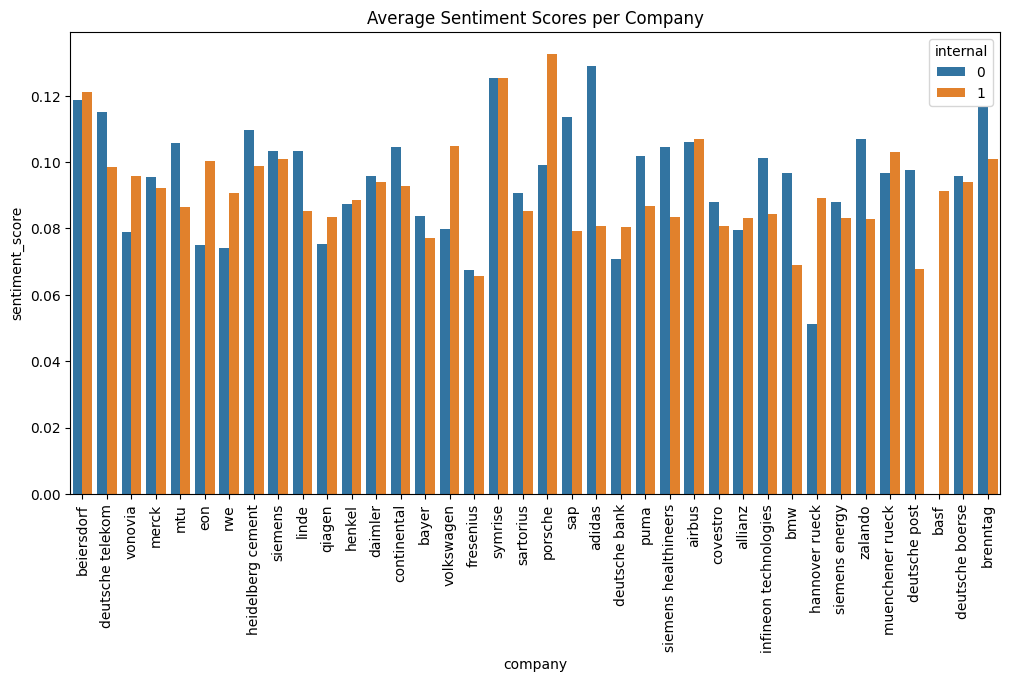

In [ ]:
# Define a function to calculate sentiment polarity using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the sentiment analysis function to the 'content' column and store the results in a new column 'sentiment_score'
df['sentiment_score'] = df['token_string'].apply(get_sentiment)

# Plot the sentiment scores
plt.figure(figsize=(12, 6))
sns.barplot(x='company', y='sentiment_score', data=df, hue='internal', errorbar=None)
plt.xticks(rotation=90)
plt.title("Average Sentiment Scores per Company")
plt.show()